In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
from orbit.models import DLT,ETS, KTRLite, LGT, ARMA
from orbit.utils.simulation import make_trend, make_regression
import torch
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components


In [20]:
from datetime import datetime, timedelta
import datetime as dt 


In [3]:
%load_ext autoreload
%autoreload 2

<class 'numpy.ndarray'>


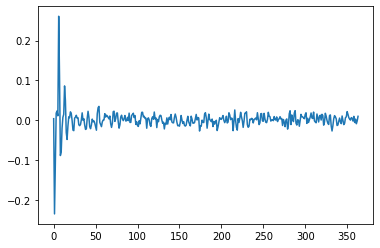

In [109]:
# make the data
n = 365 # hourly for 1 year 

x0 = np.random.normal(0, 1, n)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)
x4 = np.random.normal(0, 1, n)
x5 = np.random.normal(0, 1, n)
x6 = np.random.normal(0, 1, n)
x7 = np.random.normal(0, 1, n)
x8 = np.random.normal(0, 1, n)
x9 = np.random.normal(0, 1, n)

X = np.vstack([x0, x1]).transpose()
   
    

eta = np.random.normal(0, 0.01, n)

rho = [0.45, -0.25,0.25]
beta = [0.00, -0.00]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-2] + rho[2]*y[i-7] + x0[i]*beta[0]+ x1[i]*beta[1]+ eta[i]

     
#plt.plot(y)
plt.plot(y[1:500])
print(type(X))

In [110]:
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta
        
hours = [datetime(2013, 1, 1, 14, 00)]        

start_date = datetime(2021, 1, 1, 00, 00)
end_date = datetime(2022, 1, 1, 00, 00)
i = 0
for single_date in daterange(start_date, end_date):
    hours[i]=hours.append(single_date.strftime("%Y-%m-%d %H:%M"))       
    i += i
hours = hours[1:(n+1)]
hours = [dt.datetime.strptime(hour, "%Y-%m-%d %H:%M") for hour in hours]


In [111]:
df = pd.DataFrame(X, columns=['a1', 'a2'])
df['hours'] = hours
df['y'] = y

In [112]:
df_train = df.iloc[0:330,:]
df_test = df.iloc[330:n,:]


In [119]:
mod = ARMA(
        regressor_col=['a1', 'a2'],
        lm_first=0,
        estimator='stan-mcmc',
        date_col = 'hours',
        response_col = 'y',
        num_of_ar_lags = 2,
        ar_lags = [1,7],
        num_of_ma_lags = 1,
        ma_lags = [1] ,

)

In [120]:
mod.fit(df_train)


Gradient evaluation took 0.000342 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.42 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000514 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.14 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00067 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.7 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000337 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.37 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iter

Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 1.92273 seconds (Warm-up)
               0.054436 seconds (Sampling)
               1.97716 seconds (Total)

Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 1.94411 seconds (Warm-up)
               0.041709 seconds (Sampling)
               1.98582 seconds (Total)



In [121]:
pred = mod.predict(df)

hours
                  hours  prediction_5  prediction  prediction_95
0   2021-01-01 00:00:00     -0.000691    0.005914       0.014906
1   2021-01-01 01:00:00     -0.005558    0.001117       0.007432
2   2021-01-01 02:00:00     -0.007123   -0.000721       0.005948
3   2021-01-01 03:00:00     -0.030787    0.002795       0.035905
4   2021-01-01 04:00:00     -0.015792    0.002371       0.034140
..                  ...           ...         ...            ...
360 2021-01-16 00:00:00     -0.006769    0.010632       0.446711
361 2021-01-16 01:00:00     -0.007778    0.006124       0.502369
362 2021-01-16 02:00:00     -0.009442    0.006380       0.560820
363 2021-01-16 03:00:00     -0.008216    0.005908       0.631738
364 2021-01-16 04:00:00     -0.012243    0.002586       0.703840

[365 rows x 4 columns]
0     2021-01-01 00:00:00
1     2021-01-01 01:00:00
2     2021-01-01 02:00:00
3     2021-01-01 03:00:00
4     2021-01-01 04:00:00
              ...        
360   2021-01-16 00:00:00
361   20

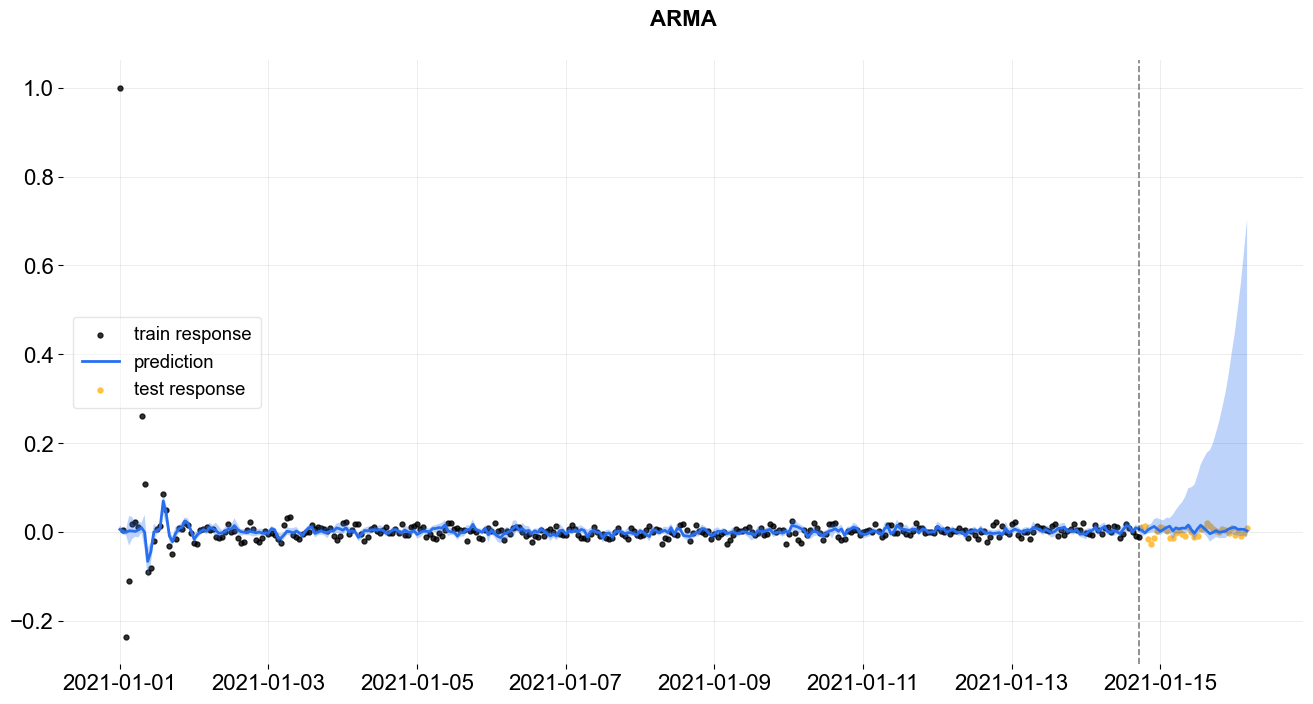

In [122]:

_ = plot_predicted_data(df_train, pred, date_col = 'hours', actual_col = 'y', title='ARMA', test_actual_df = df_test)

In [69]:
np.std(pred.iloc[8700:n,3]-df_test['y'])

4.207372571570419

In [13]:
mod.get_regression_coefs

functools.partial(<bound method ARMAModel.get_regression_coefs of <orbit.template.arma.ARMAModel object at 0x147a53b50>>, {'response': array([ 7.01404176e-01,  6.51818070e-01, -2.10264275e+00, -1.03495766e+00,
        1.88389995e+00, -1.15056750e+00, -3.88242910e+00,  6.01888263e-01,
       -1.46737925e+00, -1.09445607e+00,  1.81135522e+00, -3.47441880e+00,
       -5.72932663e+00,  1.94863753e+00, -1.27698313e-01, -1.06275612e+00,
       -3.71633348e-01,  2.58023206e+00,  1.99782694e+00,  1.28462523e+00,
       -9.91877322e-01, -7.90390793e-01,  1.10370357e+00, -6.00928991e-01,
        9.13948433e-01,  1.51111752e+00,  3.00225795e+00,  2.42191934e+00,
        1.07544687e+00,  2.61872494e+00,  2.91871733e+00, -2.10997325e+00,
       -2.22464071e+00, -7.12828569e-01, -1.21053463e+00, -6.06697617e-01,
        9.77589736e-01,  7.66750955e-01,  3.63789461e+00,  2.58035551e+00,
        2.02681016e+00,  2.87128573e+00, -2.02982930e-01,  3.76170700e+00,
        1.68179311e+00,  3.01873831e+00,